# Learning Reachability Analysis

This notebook describes my initial experiments in learning control flow graph reachability using Graph Nets.

In [1]:
# Preamble.
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
import time
from labm8 import humanize

from labm8 import viz

from deeplearning.ml4pl import ml4pl_pb2
from deeplearning.ml4pl import control_flow_graph as cfg
from deeplearning.ml4pl import control_flow_graph_generator as cfg_generator
from deeplearning.ml4pl import cfg_datasets as datasets

%matplotlib inline

In [2]:
# Plotting utils.

def GetNodeName(g: nx.DiGraph, n: int, label_entry_and_exit = True) -> str:
    """Get the name of a node in a CFG.
    
    Args:
        g: The graph.
        n: The node index.
        label_entry_and_exit: If True, use 'Entry' and 'Exit' as names for the
            entry and exit blocks, respectively.
            
    Returns:
        The node's name.
    """
    if label_entry_and_exit:
        if g.nodes[n].get('entry', False):
            return 'Entry'
        if g.nodes[n].get('exit', False):
            return 'Exit'
    return g.nodes[n]['name']

def DrawGraph(g: cfg.ControlFlowGraph, ax=None, label_entry_and_exit = True) -> None:
    """Draw a CFG.
    
    Args:
        g: The graph.
        ax: The axis to plot on.
        label_entry_and_exit: If True, use 'Entry' and 'Exit' as names for the
            entry and exit blocks, respectively.
    """
    ax = ax or plt.gca()
    nx.draw_spring(g, labels={n: GetNodeName(g, n, label_entry_and_exit) for n in g.nodes}, node_size=600)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

## Control Flow Graph Overview

The control flow graph is a connected directed graph with a single `entry` and `exit` node.

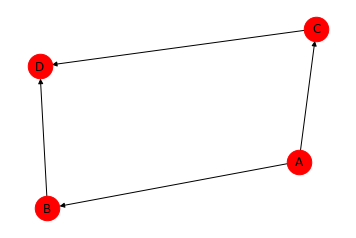

In [3]:
# Make a simple if/else CFG:
#     +----> B -----+
#     |             |
#     |             v
#     A             D
#     |             ^
#     |             |
#     +----> C -----+
g = cfg.ControlFlowGraph()
g.add_node(0, name='A', entry=True)
g.add_node(1, name='B')
g.add_node(2, name='C')
g.add_node(3, name='D', exit=True)
g.add_edge(0, 1)
g.add_edge(1, 3)
g.add_edge(0, 2)
g.add_edge(2, 3)

DrawGraph(g, label_entry_and_exit=False)

In [4]:
# Validate the CFG properties:
#
#   * nodes are named.
#   * one exit node.
#   * one entry node.
#   * outdegree(exit) == 0.
#   * outdegree(A) >= 1 for all nodes except exit.
#
# An optional "strict" mode further checks that:
#   * outdegree(A) > 1 or indegree(B) > 1 for all A->B edges.
#     i.e. no edges can be "fused".
g.IsValidControlFlowGraph(strict=True)

True

## Generating Random CFGs

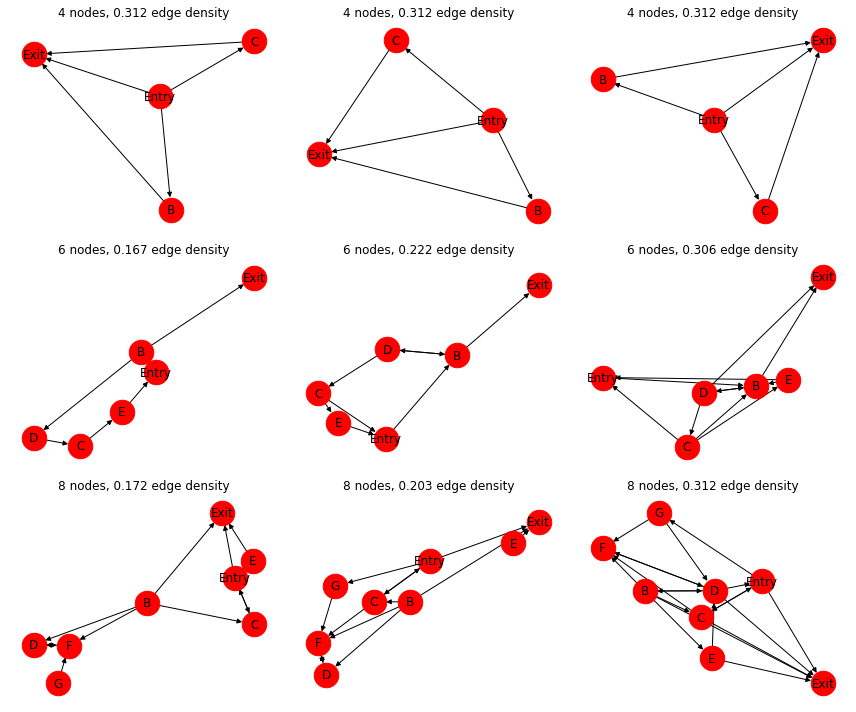

In [5]:
# Parameter sweep to draw a grid of basic blocks.
num_nodes = [4, 6, 8]
edge_densities = [0.1, 0.2, 0.3]

fig = plt.figure(figsize=(int(4 * len(edge_densities)), int(3.5 * len(num_nodes))))
fig.clf()

for j, n in enumerate(num_nodes):
    for i, ed in enumerate(edge_densities):
        ax_index = (j * len(edge_densities)) + i + 1
        ax = fig.add_subplot(len(num_nodes), len(edge_densities), ax_index)
        # Generate a graph with the requested num blocks and edge density. Use the
        # same random seed per row.
        graph = next(cfg_generator.ControlFlowGraphGenerator(
            np.random.RandomState(j), (n, n), ed, strict=False))
        DrawGraph(graph, ax=ax)
        ax.set_title(f'{n} nodes, {graph.edge_density:.3f} edge density')

viz.finalise()

### CFG Reachabilities

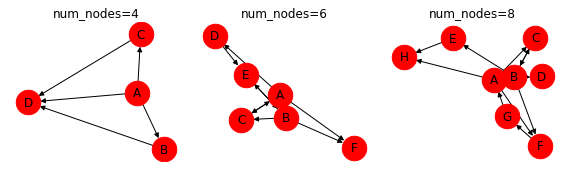

A  B  C  D  E  F  G  H
num_nodes src                        
4         A    ✘  ✓  ✓  ✓            
          B    ✘  ✘  ✘  ✓            
          C    ✘  ✘  ✘  ✓            
          D    ✘  ✘  ✘  ✘            
6         A    ✘  ✓  ✓  ✓  ✓  ✓      
          B    ✓  ✘  ✓  ✓  ✓  ✓      
          C    ✓  ✓  ✘  ✓  ✓  ✓      
          D    ✓  ✓  ✓  ✘  ✓  ✓      
          E    ✓  ✓  ✓  ✓  ✘  ✓      
          F    ✘  ✘  ✘  ✘  ✘  ✘      
8         A    ✘  ✓  ✓  ✓  ✓  ✓  ✓  ✓
          B    ✓  ✘  ✓  ✓  ✓  ✓  ✓  ✓
          C    ✓  ✓  ✘  ✓  ✓  ✓  ✓  ✓
          D    ✓  ✓  ✓  ✘  ✓  ✓  ✓  ✓
          E    ✘  ✘  ✘  ✘  ✘  ✘  ✘  ✓
          F    ✓  ✓  ✓  ✓  ✓  ✘  ✓  ✓
          G    ✓  ✓  ✓  ✓  ✓  ✓  ✘  ✓
          H    ✘  ✘  ✘  ✘  ✘  ✘  ✘  ✘

In [6]:
def BinArray(array):
    return ['✓' if x else '✘' for x in array]

fig = plt.figure(figsize=(8, 2.5))
fig.clf()

num_nodes = [4, 6, 8]

g = cfg_generator.UniqueNameSequence('A')
node_names = [g for g, _ in zip(g, range(max(num_nodes)))]
rows = []
for i, n in enumerate(num_nodes):
    graph = next(cfg_generator.ControlFlowGraphGenerator(
            np.random.RandomState(0), (n, n), 0.01, strict=False))
    ax = fig.add_subplot(1, 3, i + 1)
    DrawGraph(graph, ax=ax, label_entry_and_exit=False)
    ax.set_title(f'num_nodes={n}')
    for node in graph.nodes:
        rows.append([graph.number_of_nodes(), node_names[node]] + 
                    BinArray(graph.Reachables(node)) + 
                    [''] * (max(num_nodes) - len(graph.nodes)))

viz.finalise()
df = pd.DataFrame(rows, columns = ['num_nodes', 'src'] + node_names)
df.set_index(['num_nodes', 'src'], inplace=True)
df

### Proportion of Basic Blocks that are Reachable

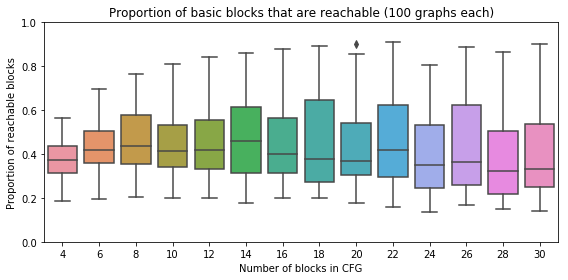

In [7]:
num_nodes = list(range(4, 31, 2))
edge_density = 0.01
num_graphs = 100

rows = []
for i, n in enumerate(num_nodes):
    generator = cfg_generator.ControlFlowGraphGenerator(
        np.random.RandomState(0), (n, n), edge_density, strict=False)
    graphs = generator.Generate(num_graphs)
    for graph in graphs:
        num_reachable = sum(sum(graph.Reachables(node)) for node in graph.nodes)
        rows.append((n, num_reachable / (graph.number_of_nodes() * graph.number_of_nodes())))

df = pd.DataFrame(rows, columns=['num_nodes', 'reachability_density'])

sns.boxplot(x='num_nodes', y='reachability_density', data=df)
plt.xlabel('Number of blocks in CFG')
plt.ylabel('Proportion of reachable blocks')
plt.title(f'Proportion of basic blocks that are reachable ({num_graphs} graphs each)')
plt.ylim((0, 1))
viz.finalise(figsize=(8, 4))

## OpenCL Dataset

In [8]:
# A dataset of CFGs from OpenCL benchmark kernels.
ocl_dataset = datasets.OpenClDeviceMappingsDataset()

ocl_dataset_graphs = ocl_dataset.cfgs_df['cfg:graph'].values

print(ocl_dataset.cfgs_df.shape)
ocl_dataset.cfgs_df.head(10)

(221, 6)


cfg:graph  \
program:benchmark_suite_name program:benchmark_name program:opencl_kernel_name                                                      
amd-app-sdk-3.0              BinomialOption         binomial_options            (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
                             BitonicSort            bitonicSort                                       (0, 1, 2, 3, 4, 5, 6, 7, 8)   
                             FastWalshTransform     fastWalshTransform                                                        (0)   
                             FloydWarshall          floydWarshallPass                                                   (0, 1, 2)   
                             MatrixMultiplication   mmmKernel                                                     (0, 1, 2, 3, 4)   
                             PrefixSum              group_prefixSum             (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
                             Reduction              reduce                                            (0, 1, 2, 3, 4, 5, 6, 7, 8)   
                             ScanLargeArrays        ScanLargeArrays                                (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)   
                                                    blockAddition                                                       (0, 1, 2)   
                                                    prefixSum                                      (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)   

                                                                                cfg:block_count  \
program:benchmark_suite_name program:benchmark_name program:opencl_kernel_name                    
amd-app-sdk-3.0              BinomialOption         binomial_options                         23   
                             BitonicSort            bitonicSort                               9   
                             FastWalshTransform     fastWalshTransform                        1   
                             FloydWarshall          floydWarshallPass                         3   
                             MatrixMultiplication   mmmKernel                                 5   
                             PrefixSum              group_prefixSum                          25   
                             Reduction              reduce                                    9   
                             ScanLargeArrays        ScanLargeArrays                          10   
                                                    blockAddition                             3   
                                                    prefixSum                                10   

                                                                                cfg:edge_count  \
program:benchmark_suite_name program:benchmark_name program:opencl_kernel_name                   
amd-app-sdk-3.0              BinomialOption         binomial_options                        30   
                             BitonicSort            bitonicSort                             11   
                             FastWalshTransform     fastWalshTransform                       0   
                             FloydWarshall          floydWarshallPass                        3   
                             MatrixMultiplication   mmmKernel                                5   
                             PrefixSum              group_prefixSum                         34   
                             Reduction              reduce                                  11   
                             ScanLargeArrays        ScanLargeArrays                         12   
                                                    blockAddition                            3   
                                                    prefixSum                               12   

                                                                                cfg:edge_density  \
program:benchmark_suite_name program:benchmark_name progr

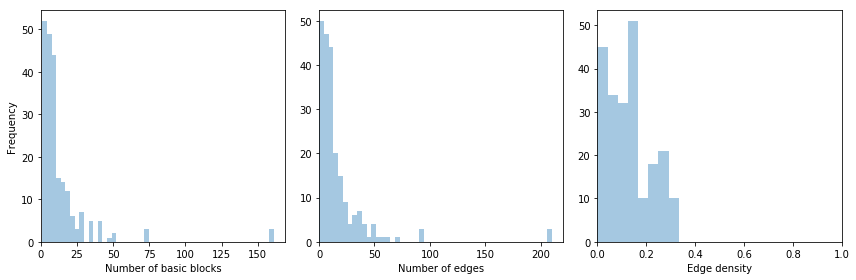

In [9]:
fig = plt.figure(figsize=(12, 4))
fig.clf()

ax = fig.add_subplot(1, 3, 1)
sns.distplot(ocl_dataset.cfgs_df['cfg:block_count'], kde=False, ax=ax)
ax.set_xlim((0, None))
ax.set_xlabel('Number of basic blocks')
ax.set_ylabel('Frequency')

ax = fig.add_subplot(1, 3, 2)
sns.distplot(ocl_dataset.cfgs_df['cfg:edge_count'], kde=False, ax=ax)
ax.set_xlim((0, None))
ax.set_xlabel('Number of edges')

ax = fig.add_subplot(1, 3, 3)
sns.distplot(ocl_dataset.cfgs_df['cfg:edge_density'], kde=False, ax=ax)
ax.set_xlim((0, 1))
ax.set_xlabel('Edge density')

viz.finalise()

In [10]:
df = ocl_dataset.cfgs_df
valid = sum(df['cfg:is_valid'].values)
strict_valid = sum(df['cfg:is_strict_valid'].values)
print(f'{valid} of {len(df)} ({valid / (len(df) or 1):.1%}) graphs are valid')
print(f'{strict_valid} of {len(df)} ({strict_valid / (len(df) or 1):.1%}) graphs are strict valid')

221 of 221 (100.0%) graphs are valid
81 of 221 (36.7%) graphs are strict valid


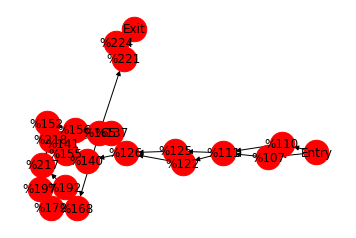

In [11]:
DrawGraph(ocl_dataset_graphs[0])

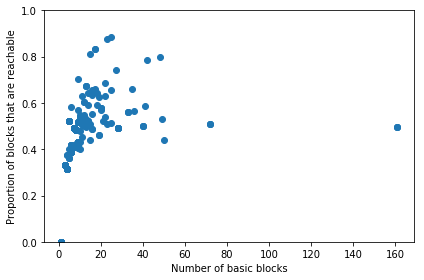

In [12]:
rows = []
for i, graph in enumerate(ocl_dataset_graphs):
    num_reachable = sum(sum(graph.Reachables(node)) for node in graph.nodes)
    rows.append((graph.number_of_nodes(), num_reachable / (graph.number_of_nodes() * graph.number_of_nodes())))

df = pd.DataFrame(rows, columns=['num_nodes', 'reachability_density'])

plt.scatter(x='num_nodes', y='reachability_density', data=df)
plt.xlabel('Number of basic blocks')
plt.ylabel('Proportion of blocks that are reachable')
plt.ylim((0, 1))
viz.finalise()

## Linux Dataset

In [13]:
linux_dataset = datasets.LinuxSourcesDataset()

linux_dataset_graphs = linux_dataset.cfgs_df['cfg:graph'].values

print(linux_dataset.cfgs_df.shape)
linux_dataset.cfgs_df.head(10)

(15294, 6)


,cfg:graph,cfg:block_count,cfg:edge_count,cfg:edge_density,cfg:is_valid,cfg:is_strict_valid
program:src_relpath,,,,,,
kernel/acct.c,(0),1,0,0.000000,True,True
kernel/acct.c,"(0, 1, 2, 3, 4, 5, 6)",7,8,0.163265,True,False
kernel/acct.c,(0),1,0,0.000000,True,True
kernel/acct.c,(0),1,0,0.000000,True,True
kernel/acct.c,(0),1,0,0.000000,True,True
kernel/acct.c,(0),1,0,0.000000,True,True
kernel/acct.c,(0),1,0,0.000000,True,True
kernel/acct.c,(0),1,0,0.000000,True,True
kernel/acct.c,(0),1,0,0.000000,True,True


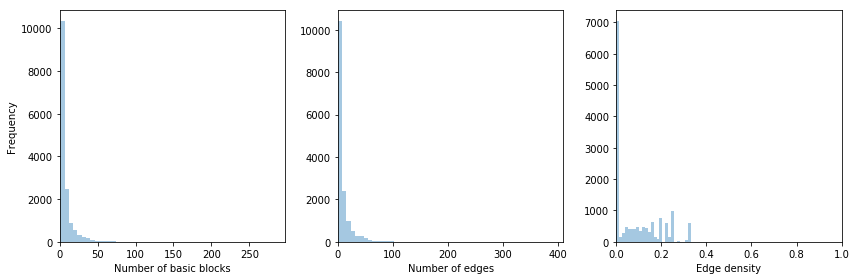

In [14]:
fig = plt.figure(figsize=(12, 4))
fig.clf()

ax = fig.add_subplot(1, 3, 1)
sns.distplot(linux_dataset.cfgs_df['cfg:block_count'], kde=False, ax=ax)
ax.set_xlim((0, None))
ax.set_xlabel('Number of basic blocks')
ax.set_ylabel('Frequency')

ax = fig.add_subplot(1, 3, 2)
sns.distplot(linux_dataset.cfgs_df['cfg:edge_count'], kde=False, ax=ax)
ax.set_xlim((0, None))
ax.set_xlabel('Number of edges')

ax = fig.add_subplot(1, 3, 3)
sns.distplot(linux_dataset.cfgs_df['cfg:edge_density'], kde=False, ax=ax)
ax.set_xlim((0, 1))
ax.set_xlabel('Edge density')

viz.finalise()

In [15]:
df = linux_dataset.cfgs_df
valid = sum(df['cfg:is_valid'].values)
strict_valid = sum(df['cfg:is_strict_valid'].values)
print(f'{valid} of {len(df)} ({valid / (len(df) or 1):.1%}) graphs are valid')
print(f'{strict_valid} of {len(df)} ({strict_valid / (len(df) or 1):.1%}) graphs are strict valid')

15294 of 15294 (100.0%) graphs are valid
11029 of 15294 (72.1%) graphs are strict valid


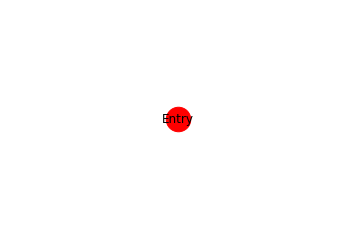

In [16]:
DrawGraph(linux_dataset_graphs[3])

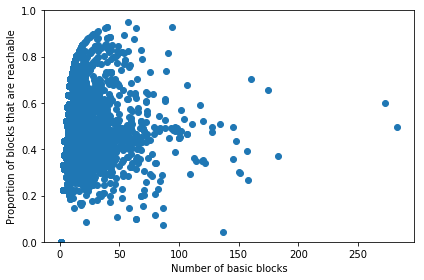

In [17]:
rows = []
for i, graph in enumerate(linux_dataset_graphs):
    num_reachable = sum(sum(graph.Reachables(node)) for node in graph.nodes)
    rows.append((graph.number_of_nodes(), num_reachable / (graph.number_of_nodes() * graph.number_of_nodes())))

df = pd.DataFrame(rows, columns=['num_nodes', 'reachability_density'])

plt.scatter(x='num_nodes', y='reachability_density', data=df)
plt.xlabel('Number of basic blocks')
plt.ylabel('Proportion of blocks that are reachable')
plt.ylim((0, 1))
viz.finalise()

## GraphNet model

### Define Features

In [19]:
# Define graph features.

import collections
import typing

TargetGraphSpec = collections.namedtuple('TargetGraphSpec', ['graph', 'target_node_index'])

# Functions to generate feature vectors. Features vectors are np.arrays of floating point
# values.

def InputGraphNodeFeatures(spec: TargetGraphSpec, node_index: int) -> np.array:
    """Extract node features for an input graph."""
    node = spec.graph.nodes[node_index]
    # If the node is the target node, the features are [0, 1]. Else, the features are [1, 0].
    return np.array([
        0 if node_index == spec.target_node_index else 1,
        1 if node_index == spec.target_node_index else 0,
    ], dtype=float)

def InputGraphEdgeFeatures(spec: TargetGraphSpec, edge_index: typing.Tuple[int, int]):
    """Extract edge features for an input graph."""
    return np.ones(1, dtype=float)

def TargetGraphNodeFeatures(spec: TargetGraphSpec, node_index: int):
    """Extract node features for a target graph."""
    reachable = spec.graph.IsReachable(spec.target_node_index, node_index)
    # If the node is reachable, the features are [0, 1]. Else, the features are [1, 0].
    return np.array([
        0 if reachable else 1,
        1 if reachable else 0,
    ], dtype=float)

def TargetGraphEdgeFeatures(spec: TargetGraphSpec, edge_index: typing.Tuple[int, int]):
    """Extract edge features for a target graph."""
    return np.ones(1, dtype=float)

def GraphToInputTarget(spec: TargetGraphSpec):
    """Produce two graphs with input and target feature vectors for training.
    
    A 'features' attributes is added node and edge data, which is a numpy array 
    of features describing the node or edge. The shape of arrays is consistent
    across input nodes, input edges, target nodes, and target edges.
    """
    input_graph = spec.graph.copy()
    target_graph = spec.graph.copy()
    
    # Set node features.
    for node_index in input_graph.nodes():
        input_graph.add_node(node_index, features=InputGraphNodeFeatures(spec, node_index))
        
    for node_index in target_graph.nodes():
        target_graph.add_node(node_index, features=TargetGraphNodeFeatures(spec, node_index))
        
    # Set edge features.
    for edge_index in input_graph.edges():
        input_graph.add_edge(*edge_index, features=InputGraphEdgeFeatures(spec, edge_index))
        
    for edge_index in target_graph.edges():
        target_graph.add_edge(*edge_index, features=TargetGraphEdgeFeatures(spec, edge_index))
    
    # Set global (graph) features.
    input_graph.graph['features'] = np.array([0.0])
    target_graph.graph['features'] = np.array([0.0])
    
    return input_graph, target_graph

graph, target_node_index = linux_dataset_graphs[1], 1
igraph, tgraph = GraphToInputTarget(TargetGraphSpec(
    graph=graph, target_node_index=target_node_index))

DrawGraph(igraph, label_entry_and_exit=False)
viz.finalise(figsize=(4, 3))

print('Input graph features:')
for node, data in igraph.nodes(data=True):
    print(f"  node {data['name']:5s} {data['features']}")
for x, y, data in igraph.edges(data=True):
    print(f"  edge {x}->{y}  {data['features']}")
print(f'  graph      {igraph.graph["features"]}')
print()
print('Target graph features:')
for node, data in tgraph.nodes(data=True):
    print(f"  node {data['name']:5s} {data['features']}")
for x, y, data in igraph.edges(data=True):
    print(f"  edge {x}->{y}  {data['features']}")
print(f'  graph      {igraph.graph["features"]}')

NetworkXError: The node 1 is not in the graph.

In [20]:
from graph_nets import utils_tf as graph_net_utils_tf

def CreatePlaceholdersFromGraphs(graphs: typing.List[cfg.ControlFlowGraph], 
                                 batch_size: int):
    """Creates placeholders for the model training and evaluation.

    Args:
        graphs: A list of graphs that will be inspected for vector sizes.
        batch_size: Total number of graphs per batch.

    Returns:
        A tuple of the input graph's and target graph's placeholders, as a
        graph namedtuple.
    """
    input_graphs, target_graphs = zip(*[GraphToInputTarget(g) for g in graphs])
    
    input_ph = graph_net_utils_tf.compat.v1.placeholders_from_networkxs(
      input_graphs, force_dynamic_num_graphs=True)
    target_ph = graph_net_utils_tf.compat.v1.placeholders_from_networkxs(
      target_graphs, force_dynamic_num_graphs=True)
    return input_ph, target_ph

def PrintGraphTuple(gt):
    print('nodes', gt.nodes)
    print('edges', gt.edges)
    print('receivers', gt.receivers)
    print('senders', gt.senders)
    print('globals', gt.globals)
    print('n_node', gt.n_node)
    print('n_edge', gt.n_edge)
    
def MakeRunnableInSession(*args):
    """Lets an iterable of TF graphs be output from a session as NP graphs."""
    return [graph_net_utils_tf.make_runnable_in_session(a) for a in args]

/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/docs/wip_graph/notebooks/notebooks.runfiles/pypi__h5py_2_7_1/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [21]:
class SpecGenerator(object):
    
    def __init__(self, graphs: typing.Iterator[cfg.ControlFlowGraph]):
        self._graphs = graphs

    def Generate(self, n: int = 0):
        """Generate specs.
        
        Args:
            n: The maximum number of spec to generatte. If zero, enumerate
                all graphs.
        """
        i = 0
        for g in self._graphs:
            for nn in range(g.number_of_nodes()):
                i += 1
                if n and i > n:
                    return
                yield TargetGraphSpec(graph=g, target_node_index=nn)

In [22]:
def CreateLossOps(target_op, output_ops):
    return [
        tf.losses.softmax_cross_entropy(target_op.nodes, output_op.nodes) +
        tf.losses.softmax_cross_entropy(target_op.edges, output_op.edges)
        for output_op in output_ops
    ]

### Define Model

In [23]:
# Define model.
from graph_nets.demos import models
import tensorflow as tf

tf.reset_default_graph()

seed = 0

# Data / training parameters.
num_training_iterations = 5000
batch_size_tr = 32
batch_size_ge = 100
edge_density_tr = .01
edge_density_ge = .01
# Number of nodes per graph sampled uniformly from this range.
num_nodes_min_max_tr = (5, 20)
num_nodes_min_max_ge = (15, 25)

graph_generator_tr = cfg_generator.ControlFlowGraphGenerator(
    np.random.RandomState(seed), num_nodes_min_max_tr, edge_density_tr, strict=False)
spec_generator_tr = SpecGenerator(graph_generator_tr)

# Data.
specs_tr = list(spec_generator_tr.Generate(min(num_training_iterations, 1000)))
# Input and target placeholders.
input_ph, target_ph = CreatePlaceholdersFromGraphs(specs_tr, batch_size_tr)

def GetNumberOfMessagePassingSteps(specs) -> int:
    # TODO(cec): Determine the number of required message parsing steps.
    return max(s.graph.number_of_edges() for s in specs)

num_processing_steps_tr = GetNumberOfMessagePassingSteps(specs_tr)
# TODO: We haven't generated evaluation graphs yet, so we use the same
# number of message passing steps as we do for training.
num_processing_steps_ge = num_processing_steps_tr

print(f'{num_processing_steps_tr} message passing steps for training')
print(f'{num_processing_steps_ge} message passing steps for evaluation')

# Connect the data to the model.
# Instantiate the model.
# TODO: What is the edge output and node output size exactly?
model = models.EncodeProcessDecode(edge_output_size=1, node_output_size=2)
# A list of outputs, one per processing step.
output_ops_tr = model(input_ph, num_processing_steps_tr)
output_ops_ge = model(input_ph, num_processing_steps_ge)

# Training loss.
loss_ops_tr = CreateLossOps(target_ph, output_ops_tr)
# Loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr
# Test/generalization loss.
loss_ops_ge = CreateLossOps(target_ph, output_ops_ge)
loss_op_ge = loss_ops_ge[-1]  # Loss from final processing step.

# Optimizer.
learning_rate = 1e-3
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

# Lets an iterable of TF graphs be output from a session as NP graphs.
input_ph, target_ph = MakeRunnableInSession(input_ph, target_ph)

36 message passing steps for training
36 message passing steps for evaluation


/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/docs/wip_graph/notebooks/notebooks.runfiles/pypi__tensorflow_1_8_0/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [24]:
from graph_nets import utils_np as graph_net_utils_np

def CreateFeedDict(graphs: typing.List[cfg.ControlFlowGraph], 
                   input_ph, target_ph):
    """Creates placeholders for the model training and evaluation.

    Args:
        graphs: A list of graphs that will be inspected for vector sizes.
            batch_size: Total number of graphs per batch.
        input_ph: The input graph's placeholders, as a graph namedtuple.
        target_ph: The target graph's placeholders, as a graph namedtuple.

    Returns:
        feed_dict: The feed `dict` of input and target placeholders and data.
        raw_graphs: The `dict` of raw networkx graphs.
    """
    graphs = list(graphs)
    input_graphs, target_graphs = zip(*[GraphToInputTarget(g) for g in graphs])
    
    input_graphs = graph_net_utils_np.networkxs_to_graphs_tuple(input_graphs)
    target_graphs = graph_net_utils_np.networkxs_to_graphs_tuple(target_graphs)
    feed_dict = {input_ph: input_graphs, target_ph: target_graphs}
    return feed_dict, graphs

In [25]:
from labm8 import decorators

class ReachabilityModelEvaluator(object):
    
    def __init__(self, specs: typing.List[TargetGraphSpec], 
                 predicted_reachabilities: typing.List[np.array],
                 data = None):
        self._specs = specs
        self._predicted_reachabilities = predicted_reachabilities
        self.data = data or {}
        if len(self._specs) != len(self._predicted_reachabilities):
            raise ValueError

    @decorators.memoized_property
    def _correct_solved(self):
        cs = []
        ss = []
        for spec, predicted in zip(self._specs, self._predicted_reachabilities):
            reachables = [spec.graph.IsReachable(spec.target_node_index, node_index) for node_index in spec.graph.node]
            if len(predicted) != len(reachables):
                raise ValueError
            c = [reachables == predicted]
            c = np.concatenate(c, axis=0)
            s = np.all(c)
            cs.append(c)
            ss.append(s)
        correct = np.mean(np.concatenate(cs, axis=0))
        solved = np.mean(np.stack(ss))
        return correct, solved
    
    @property
    def correct_incorrect_graph_evaluators(self):
        """Return a pair of ReachabilityModelEvaluator instances, one filtered with
        only the correctly labeled graphs, the other with only the incorrectly 
        labeled graphs."""
        correct_specs, incorrect_specs = [], []
        correct_predictions, incorrect_predictions = [], []
        
        for spec, predicted in zip(self._specs, self._predicted_reachabilities):
            reachables = [spec.graph.IsReachable(spec.target_node_index, node_index) for node_index in spec.graph.node]
            if len(predicted) != len(reachables):
                raise ValueError
            if np.all([reachables == predicted]):
                correct_specs.append(spec)
                correct_predictions.append(predicted)
            else:
                incorrect_specs.append(spec)
                incorrect_predictions.append(predicted)
        
        correct = ReachabilityModelEvaluator(correct_specs, correct_predictions, data)
        incorrect = ReachabilityModelEvaluator(incorrect_specs, incorrect_predictions, data)
        return correct, incorrect
    
    @property
    def specs(self):
        return self._specs
    
    @property
    def correct_nodes(self):
        return self._correct_solved[0]
    
    @property
    def correct_graphs(self):
        return self._correct_solved[1]
    
    def ToDict(self):
        
        def _MinMedMax(array):
            array = np.array(array)
            return array.min(), int(np.median(array)), array.max()
        
        data = self.data.copy()
        data.update({
            'num_specs': len(self._specs),
            'num_unique_graphs': len(set(s.graph for s in self._specs)),
            'node_count_min_med_max': _MinMedMax([s.graph.number_of_nodes() for s in self._specs]),
            'edge_count_min_med_max': _MinMedMax([s.graph.number_of_edges() for s in self._specs]),
            'correct_nodes': self.correct_nodes,
            'correct_graphs': self.correct_graphs,
        })
        return data

def EvaluateGraphNetValuesDict(specs, values_dict, **kwargs):
    predicted_reachabilities = [
        np.argmax(d['nodes'], axis=-1) for d in 
        graph_net_utils_np.graphs_tuple_to_data_dicts(values_dict["outputs"][-1])
    ]
    return ReachabilityModelEvaluator(specs, predicted_reachabilities, kwargs)
    
def EvaluateGraphNet(specs, **kwargs):
    feed_dict, specs = CreateFeedDict(specs, input_ph, target_ph)
    values = sess.run({
        "target": target_ph,
        "loss": loss_op_ge,
        "outputs": output_ops_ge
    }, feed_dict=feed_dict)
    return EvaluateGraphNetValuesDict(specs, values, loss=values['loss'], **kwargs)

### Reset Session

In [26]:
# This cell resets the Tensorflow session, but keeps the same computational
# graph.

tf.set_random_seed(0)

try:
    sess.close()
except NameError:
    pass
sess = tf.compat.v1.Session()

sess.run(tf.global_variables_initializer())

last_iteration = 0

# ReachabilityModelEvaluator.ToDict() dictionaries.
eval_dicts_tr = []
eval_dicts_ge = []

# Record hashes of all graphs seen during training and testing. 
graph_hashes_tr = set()
graph_hashes_ge = set()

### XXX: Create datasets

In [ ]:
data_generator = SpecGenerator(cfg_generator.ControlFlowGraphGenerator(
        np.random.RandomState(seed), num_nodes_min_max_tr, edge_density_tr, strict=False))
train_specs = data_generator.Generate(2000)

def SpecsToDataFrame(specs: typing.Iterator[TargetGraphSpec], split_type):
    rows = [ {
        'networkx:input_graph': x[0],
        'networkx:target_graph': x[1],
        'split:type': split_type,
    }
        for x in [GraphToInputTarget(s) for s in specs]
    ]
    return pd.DataFrame(rows)

df = SpecsToDataFrame(train_specs, 'training')
df

,networkx:input_graph,networkx:target_graph,split:type
0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",training
1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",training
2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",training
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",training
4,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",training
5,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",training
6,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",training
7,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",training
8,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",training
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",training


In [ ]:
df['networkx:input_graph'].values[0]

In [ ]:
print("done!")

done!


### Run training

In [49]:
# You can interrupt this cell's training loop at any time, and visualize the
# intermediate results by running the next cell (below). You can then resume
# training by simply executing this cell again.

# How much time between logging and printing the current results.
log_every_seconds = 10

if last_iteration:
    print(f'Resuming {humanize.Commas(last_iteration)} / {humanize.Commas(num_training_iterations)} '
          'training iterations')
else:
    print(f'Beginning {humanize.Commas(num_training_iterations)} training iterations')

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
    seed += 1
    last_iteration = iteration
    data_generator = SpecGenerator(cfg_generator.ControlFlowGraphGenerator(
        np.random.RandomState(seed), num_nodes_min_max_tr, edge_density_tr, strict=False))
    train_specs = data_generator.Generate(batch_size_tr)
    feed_dict, train_specs = CreateFeedDict(train_specs, input_ph, target_ph)
    train_values = sess.run({
        "step": step_op,
        "target": target_ph,
        "loss": loss_op_tr,
        "outputs": output_ops_tr
    }, feed_dict=feed_dict)
    
    # Record the hashes of all training graphs.
    [graph_hashes_tr.add(s.graph.IsomorphicHash()) for s in train_specs]
    
    the_time = time.time()
    elapsed_since_last_log = the_time - last_log_time
    if elapsed_since_last_log > log_every_seconds:
        last_log_time = the_time
        data_generator = SpecGenerator(cfg_generator.ControlFlowGraphGenerator(
            np.random.RandomState(seed + 1), num_nodes_min_max_ge, edge_density_ge, strict=False))
        test_specs = list(data_generator.Generate(batch_size_ge))

        # Record the hashes of all testing graphs.
        [graph_hashes_ge.add(s.graph.IsomorphicHash()) for s in test_specs]
        
        train_results = EvaluateGraphNetValuesDict(
            train_specs, train_values, iteration=iteration, 
            loss=train_values["loss"], 
            total_uniq_graphs=len(graph_hashes_tr)).ToDict()
        test_results = EvaluateGraphNet(
            test_specs, iteration=iteration, 
            total_uniq_graphs=len(graph_hashes_ge),
            num_uniq_unseen_graphs=(len(graph_hashes_ge - graph_hashes_tr))).ToDict()

        elapsed = time.time() - start_time
        eval_dicts_tr.append(train_results)
        eval_dicts_ge.append(test_results)
        print(f'T {elapsed:.0f}s  #{train_results["iteration"]}  Train loss {train_results["loss"]:.4f}  '
              f'Test accuracy (node={test_results["correct_nodes"]:.1%}, '
              f'graph={test_results["correct_graphs"]:.1%})')

Beginning 5,000 training iterations
T 52s  #0  Train loss 0.8102  Test accuracy (node=27.1%, graph=1.0%)
T 59s  #16  Train loss 0.6990  Test accuracy (node=68.6%, graph=7.0%)
T 69s  #43  Train loss 0.5076  Test accuracy (node=79.1%, graph=18.0%)
T 79s  #71  Train loss 0.3950  Test accuracy (node=79.6%, graph=23.0%)
T 89s  #98  Train loss 0.5734  Test accuracy (node=69.3%, graph=2.0%)
T 99s  #126  Train loss 0.5267  Test accuracy (node=67.6%, graph=1.0%)
T 109s  #154  Train loss 0.4586  Test accuracy (node=68.9%, graph=3.0%)
T 120s  #181  Train loss 0.3845  Test accuracy (node=71.8%, graph=14.0%)
T 130s  #208  Train loss 0.4338  Test accuracy (node=80.3%, graph=26.0%)
T 140s  #235  Train loss 0.4985  Test accuracy (node=70.0%, graph=1.0%)
T 150s  #261  Train loss 0.4902  Test accuracy (node=67.8%, graph=0.0%)
T 160s  #286  Train loss 0.5682  Test accuracy (node=70.7%, graph=25.0%)
T 171s  #312  Train loss 0.4133  Test accuracy (node=69.4%, graph=6.0%)
T 181s  #336  Train loss 0.3119  Te

T 1180s  #2861  Train loss 0.0520  Test accuracy (node=100.0%, graph=100.0%)
T 1190s  #2886  Train loss 0.0502  Test accuracy (node=100.0%, graph=100.0%)
T 1200s  #2910  Train loss 0.0353  Test accuracy (node=100.0%, graph=100.0%)
T 1210s  #2935  Train loss 0.0396  Test accuracy (node=100.0%, graph=100.0%)
T 1221s  #2962  Train loss 0.0472  Test accuracy (node=100.0%, graph=100.0%)
T 1231s  #2988  Train loss 0.0819  Test accuracy (node=100.0%, graph=100.0%)
T 1241s  #3013  Train loss 0.1654  Test accuracy (node=100.0%, graph=100.0%)
T 1252s  #3039  Train loss 0.0427  Test accuracy (node=100.0%, graph=100.0%)
T 1261s  #3064  Train loss 0.0620  Test accuracy (node=100.0%, graph=100.0%)
T 1272s  #3089  Train loss 0.0371  Test accuracy (node=100.0%, graph=100.0%)
T 1282s  #3109  Train loss 0.0374  Test accuracy (node=100.0%, graph=100.0%)
T 1292s  #3134  Train loss 0.0421  Test accuracy (node=95.4%, graph=90.0%)
T 1302s  #3160  Train loss 0.0343  Test accuracy (node=100.0%, graph=100.0%)
T

### Evaluate Training

In [51]:
# Table of training and testing stats.

df = pd.concat((pd.DataFrame(eval_dicts_tr).add_suffix('_tr'), 
                pd.DataFrame(eval_dicts_ge).add_suffix('_ge')), axis=1)
assert np.array_equal(df.iteration_tr.values, df.iteration_ge.values)
df.set_index('iteration_tr', inplace=True)
df.drop(columns=[
    'iteration_ge',
], inplace=True)
df.index.name = 'iteration'
df.sort_index(inplace=True)
df.tail(20)

,correct_graphs_tr,correct_nodes_tr,edge_count_min_med_max_tr,loss_tr,node_count_min_med_max_tr,num_specs_tr,num_unique_graphs_tr,total_uniq_graphs_tr,correct_graphs_ge,correct_nodes_ge,edge_count_min_med_max_ge,loss_ge,node_count_min_med_max_ge,num_specs_ge,num_uniq_unseen_graphs_ge,num_unique_graphs_ge,total_uniq_graphs_ge
iteration,,,,,,,,,,,,,,,,,
4510,1.00000,1.000000,"(5, 18, 28)",0.034010,"(5, 11, 14)",32,4,14249,1.00,1.000000,"(30, 33, 45)",0.000930,"(16, 20, 24)",100,984,6,984
4537,1.00000,1.000000,"(23, 30, 32)",0.038907,"(14, 16, 16)",32,3,14329,1.00,1.000000,"(25, 32, 44)",0.001025,"(15, 20, 24)",100,990,6,990
4565,1.00000,1.000000,"(11, 19, 24)",0.042727,"(7, 11, 15)",32,3,14424,1.00,1.000000,"(23, 38, 46)",0.000729,"(15, 20, 24)",100,996,6,996
4593,1.00000,1.000000,"(19, 27, 28)",0.036131,"(11, 14, 15)",32,3,14518,1.00,1.000000,"(25, 31, 45)",0.000737,"(15, 18, 24)",100,1002,6,1002
4622,1.00000,1.000000,"(15, 26, 26)",0.114146,"(9, 15, 17)",32,3,14613,1.00,1.000000,"(23, 36, 44)",0.003269,"(15, 20, 24)",100,1008,6,1008
4647,0.96875,0.969231,"(5, 19, 24)",0.243774,"(6, 12, 13)",32,4,14691,0.97,0.996795,"(22, 35, 40)",0.029288,"(15, 21, 22)",100,1014,6,1014
4672,0.90625,0.944334,"(24, 31, 31)",0.382146,"(14, 17, 18)",32,3,14768,0.22,0.595925,"(24, 27, 42)",2.698375,"(15, 16, 22)",100,1020,6,1020
4697,0.03125,0.659656,"(7, 37, 37)",0.589474,"(6, 19, 19)",32,3,14846,0.14,0.719661,"(24, 34, 44)",0.539810,"(16, 18, 24)",100,1026,6,1026
4722,0.21875,0.886861,"(26, 35, 35)",0.435210,"(16, 18, 18)",32,2,14923,0.23,0.803089,"(26, 38, 45)",0.470432,"(16, 21, 24)",100,1031,5,1031


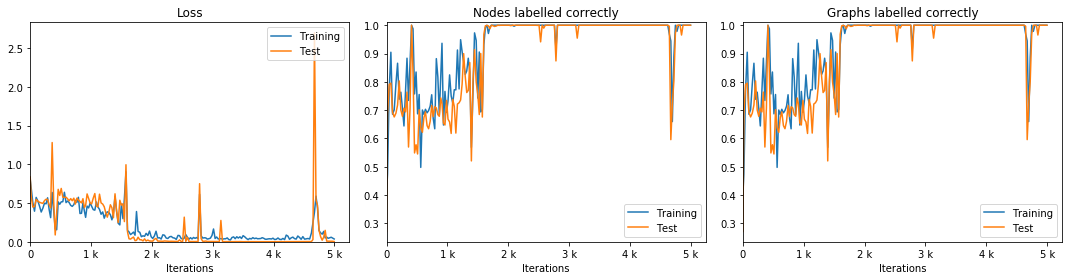

In [57]:
from matplotlib.ticker import EngFormatter

fig = plt.figure(figsize=(15, 4))
fig.clf()

ax = fig.add_subplot(1, 3, 1)
ax.plot(df.index, df.loss_tr, label='Training')
ax.plot(df.index, df.loss_ge, label='Test')
ax.xaxis.set_major_formatter(EngFormatter(places=0))
ax.set_ylim((0, None))
ax.set_xlim((0, None))
ax.set_xlabel('Iterations')
ax.set_title('Loss')
ax.legend(loc='upper right')

ax = fig.add_subplot(1, 3, 2)
ax.plot(df.index, df.correct_nodes_tr, label='Training')
ax.plot(df.index, df.correct_nodes_ge, label='Test')
ax.xaxis.set_major_formatter(EngFormatter(places=0))
ax.set_ylim((None, 1.01))
ax.set_xlim((0, None))
ax.set_xlabel('Iterations')
ax.set_title('Nodes labelled correctly')
ax.legend(loc='lower right')

ax = fig.add_subplot(1, 3, 3)
ax.plot(df.index, df.correct_nodes_tr, label='Training')
ax.plot(df.index, df.correct_nodes_ge, label='Test')
ax.xaxis.set_major_formatter(EngFormatter(places=0))
ax.set_ylim((None, 1.01))
ax.set_xlim((0, None))
ax.set_xlabel('Iterations')
ax.set_title('Graphs labelled correctly')
ax.legend(loc='lower right')

viz.finalise()

### Test on OpenCL Graphs

In [69]:
generator = SpecGenerator(ocl_dataset.cfgs_df['cfg:graph'].values)
ocl_graphs = list(generator.Generate())

ocl_r = EvaluateGraphNet(ocl_graphs, name="OpenCL")
ocl_r.ToDict()

{'loss': 0.3741087317466736,
 'name': 'OpenCL',
 'num_specs': 3022,
 'num_unique_graphs': 188,
 'node_count_min_med_max': (3, 23, 161),
 'edge_count_min_med_max': (3, 31, 210),
 'correct_nodes': 0.9382783935100548,
 'correct_graphs': 0.9156187954996691}

In [72]:
# Evaluating errors.
ocl_correct_r, ocl_incorrect_r = ocl_r.correct_incorrect_graph_evaluators

print(f'{len(ocl_incorrect_r.specs)} of {len(ocl_r.specs)} graphs not solved')

255 of 3022 graphs not solved


In [61]:
# Evaluating errors.
ocl_incorrect_specs = []
ocl_incorrect_predictions = []

for spec, predicted in zip(ocl_r._specs, ocl_r._predicted_reachabilities):
    reachables = [spec.graph.IsReachable(spec.target_node_index, node_index) for node_index in spec.graph.node]
    if len(predicted) != len(reachables):
        raise ValueError
    if not np.all(reachables == predicted):
        ocl_incorrect_specs.append(spec)
        ocl_incorrect_predictions.append(predicted)

print(f'{len(ocl_incorrect_specs)} of {len(ocl_r._specs)} graphs not solved')

255 of 3022 graphs not solved


In [63]:
num_nodes = np.array([s.graph.number_of_nodes() for s in ocl_incorrect_specs])
print(num_nodes.mean())


155.68627450980392


In [54]:
ones_r = ReachabilityModelEvaluator(
    ocl_graphs,
    [np.ones(s.graph.number_of_nodes()) for s in ocl_graphs], {'rule': 'Always reachable'})
zeros_r = ReachabilityModelEvaluator(
    ocl_graphs,
    [np.zeros(s.graph.number_of_nodes()) for s in ocl_graphs], {'rule': 'Never reachable'})

ocl_zero_r = max(ones_r, zeros_r, key=lambda r: r.correct_nodes)
ocl_zero_r.ToDict()

{'rule': 'Always reachable',
 'num_specs': 3022,
 'num_unique_graphs': 188,
 'node_count_min_med_max': (3, 23, 161),
 'edge_count_min_med_max': (3, 31, 210),
 'correct_nodes': 0.522094949725777,
 'correct_graphs': 0.0}

### Test on Linux Graphs

In [55]:
generator = SpecGenerator(linux_dataset.cfgs_df['cfg:graph'].values)
linux_graphs = list(generator.Generate(2000))

linux_r = EvaluateGraphNet(linux_graphs, name="Linux")
linux_r.ToDict()

{'loss': 0.004715357907116413,
 'name': 'Linux',
 'num_specs': 2000,
 'num_unique_graphs': 198,
 'node_count_min_med_max': (3, 14, 38),
 'edge_count_min_med_max': (2, 17, 51),
 'correct_nodes': 1.0,
 'correct_graphs': 1.0}

In [56]:
ones_r = ReachabilityModelEvaluator(
    linux_graphs,
    [np.ones(s.graph.number_of_nodes()) for s in linux_graphs], {'rule': 'Always reachable'})
zeros_r = ReachabilityModelEvaluator(
    linux_graphs,
    [np.zeros(s.graph.number_of_nodes()) for s in linux_graphs], {'rule': 'Never reachable'})

linux_zero_r = max(ones_r, zeros_r, key=lambda r: r.correct_nodes)
linux_zero_r.ToDict()

{'rule': 'Never reachable',
 'num_specs': 2000,
 'num_unique_graphs': 198,
 'node_count_min_med_max': (3, 14, 38),
 'edge_count_min_med_max': (2, 17, 51),
 'correct_nodes': 0.5358208008122343,
 'correct_graphs': 0.1025}